In [1]:
import torch
import torch.nn as nn
import transformers
import datasets
import torch.nn.functional as F

from tqdm.auto import tqdm
from transformers.modeling_utils import PreTrainedModel
from transformers.modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling
from transformers.activations import ACT2FN
from transformers import CLIPConfig, CLIPTextConfig, CLIPVisionConfig, CLIPModel, CLIPProcessor, CLIPPreTrainedModel

from transformers import CLIPPreTrainedModel, CLIPModel
from transformers.models.clip.modeling_clip import CLIPOutput
from transformers import Trainer, TrainingArguments
from typing import Optional, Union, Tuple
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers.modeling_outputs import ImageClassifierOutput
import torch

comet_ml is installed but `COMET_API_KEY` is not set.
2023-12-10 15:06:54.193279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 15:06:54.193358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 15:06:54.193383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 15:06:54.200972: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler fla

In [2]:
from datasets import load_dataset

dataset = load_dataset("Andron00e/CIFAR100-custom")
dataset = dataset["train"].train_test_split(test_size=0.2)
from datasets import DatasetDict

val_test = dataset["test"].train_test_split(test_size=0.5)
dataset = DatasetDict({
    "train": dataset["train"],
    "validation": val_test["train"],
    "test": val_test["test"],
})

In [3]:
def remove_prefixes(strings):
    prefixes = ['a', 'an', 'the']
    result = []

    for string in strings:
        words = string.split()
        if words[0].lower() in prefixes:
            result.append(' '.join(words[1:]))
        else:
            result.append(string)

    return result

with open("conceptnet_cifar100_filtered_new.txt", "r") as f:
    concepts = f.read().lower().split("\n")
    concepts = remove_prefixes(concepts)

In [4]:
def contrastive_loss(logits, dim: int):
    neg_ce = torch.diag(F.log_softmax(logits, dim=dim))
    return -neg_ce.mean()

def clip_loss(similarity: torch.Tensor) -> torch.Tensor:
    """
    Args:
        similarity: is equal to logits_per_image
    """
    caption_loss = contrastive_loss(similarity, dim=0)
    image_loss = contrastive_loss(similarity, dim=1)
    return (caption_loss + image_loss) / 2.0

In [5]:
import datasets
import numpy as np

metric = datasets.load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_2667988/1244638267.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("accuracy")


In [6]:
def collate_fn_test(batch):
    return {
        'image': [x['image'] for x in batch],
        'labels': [x['labels'] for x in batch]
    }

In [7]:
train_loader = torch.utils.data.DataLoader(dataset["train"], batch_size=32, shuffle=True, collate_fn=collate_fn_test, pin_memory=True)
val_loader = torch.utils.data.DataLoader(dataset["validation"], batch_size=32, shuffle=False, collate_fn=collate_fn_test, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset["test"], batch_size=32, shuffle=False, collate_fn=collate_fn_test, pin_memory=True)

In [8]:
from tqdm.auto import tqdm
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer

def preprocess_loader(loader, concepts: list):
    preprocessed_batches = []
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    for batch in tqdm(loader):
        preprocessed_batch = preprocess_batch(batch, processor, concepts)
        preprocessed_batches.append(preprocessed_batch)
    return preprocessed_batches

def preprocess_batch(batch, processor, concepts: list):
    return processor(text=concepts, images=batch['image'], return_tensors="pt", padding=True), batch['labels']

In [9]:
train_loader_preprocessed = preprocess_loader(train_loader, concepts)
val_loader_preprocessed = preprocess_loader(val_loader, concepts)
test_loader_preprocessed = preprocess_loader(test_loader, concepts)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

In [86]:
import torch
import torch.nn as nn
from typing import Optional
from torch.nn import CrossEntropyLoss
from transformers import CLIPConfig, CLIPModel, CLIPProcessor, CLIPPreTrainedModel


class TestModel(CLIPPreTrainedModel):
    def __init__(self, config: CLIPConfig, num_labels: int, num_concepts: int):
        super().__init__(config)
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        for p in self.clip.parameters():
            p.requires_grad = False
        self.num_labels = num_labels
        self.num_concepts = num_concepts
        self.cbl = nn.Linear(self.config.projection_dim, num_concepts)
        self.heads = nn.ModuleList([
            nn.Linear(num_concepts, num_labels // 10)
            for _ in range(10)
        ])
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        return_loss: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        labels: Optional[torch.Tensor] = None,
    ):
        clip_outputs = self.clip(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            position_ids=position_ids,
            return_loss=return_loss,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        cbl_outputs = self.cbl(clip_outputs.image_embeds)
        
        loss = None
        logits = torch.cat([head(cbl_outputs) for head in self.heads], dim=-1)
        
        if labels is not None: 
            split_labels = torch.split(labels, self.num_labels // len(self.heads), dim=-1)

            losses = []
            for i, head_logits in enumerate(logits.chunk(10, dim=-1)):
                head_labels = split_labels[i]
                head_loss = CrossEntropyLoss()(head_logits, head_labels)
                losses.append(head_loss)

            loss = sum(losses) / len(self.heads)

        return {"loss": loss, "logits": logits}


In [11]:
import configs

configs.set_seed(42)
device = configs.set_device(2)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [87]:
config = CLIPConfig.from_pretrained('openai/clip-vit-base-patch32')
model = TestModel(config, num_labels=100, num_concepts=len(concepts))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Number of trainable parameters is: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad == True)))

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)           

Number of trainable parameters is: 578772


In [91]:
model.to(device)
for batch in train_loader_preprocessed:
    inputs, labels = batch
    inputs = inputs.to(device)
    print(model(**inputs)['logits'])
    break

tensor([[ 0.0563, -0.0176,  0.0171,  ...,  0.0151, -0.0007, -0.0267],
        [ 0.0469, -0.0025,  0.0207,  ...,  0.0196, -0.0184, -0.0260],
        [ 0.0502, -0.0048,  0.0171,  ...,  0.0216,  0.0044, -0.0354],
        ...,
        [ 0.0513, -0.0141,  0.0233,  ...,  0.0069, -0.0152, -0.0341],
        [ 0.0458, -0.0114,  0.0200,  ...,  0.0100, -0.0088, -0.0362],
        [ 0.0504, -0.0008,  0.0172,  ...,  0.0129, -0.0183, -0.0287]],
       device='cuda:0', grad_fn=<CatBackward0>)


In [14]:
@torch.no_grad()
@torch.cuda.amp.autocast()
def val_loss_accuracy(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    val_losses = []
    for batch in tqdm(loader):
        inputs, labels = batch
        inputs = inputs.to(device)

        logits_per_image, logits = model(**inputs)
        targets = torch.tensor(labels, dtype=torch.long)
        ce_loss = criterion(logits, targets.to(device))
        cbl_loss = clip_loss(logits_per_image.to(device))
        total_loss = ce_loss + cbl_loss
        val_losses.append(total_loss.item())
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

    val_accuracy = metric.compute(predictions=all_preds, references=all_labels)
    avg_val_loss = sum(val_losses) / len(val_losses)

    return val_accuracy, avg_val_loss

@torch.no_grad()
@torch.cuda.amp.autocast()
def get_test_accuracy(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in tqdm(loader):
        inputs, labels = batch
        inputs = inputs.to(device)

        logits_per_image, logits = model(**inputs)
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

    test_accuracy = metric.compute(predictions=all_preds, references=all_labels)

    return test_accuracy

In [30]:
import os
import json
import pandas as pd
from typing import Union
import matplotlib.pyplot as plt

class TrainerLogger:
    def __init__(self, logging_dir: Union[str, None]=None):
        self.logging_dir = logging_dir
        if logging_dir != None:
            os.makedirs(self.logging_dir, exist_ok=True)
        self.history = {"epoch": [], "Loss/Train": [], "Loss/Validation": [], "Accuracy/Validation": [], "Accuracy/Test": []}

    def log(self, values):
        for key, value in values.items():
            if key in self.history:
                self.history[key].append(value)
            else:
                self.history[key] = [value]
                
        self.save_to_json("history")

    def save_to_json(self, filename):
        if self.logging_dir is not None:
            filepath = os.path.join(self.logging_dir, f"{filename}.json")
            with open(filepath, 'w') as json_file:
                json.dump(self.history, json_file)

    def plot_summary(self, key):
        if key not in self.history:
            print(f"Key '{key}' not found in history.")
            return

        if key == "Accuracy/Test":
            df = pd.DataFrame({key: [key], 'Percentage': self.history[key]})
            ax = df.plot.barh(x=key, y='Percentage')
            ax.set_xlim(0, 1)
            ax.set_xlabel("Percentage")
            ax.set_title("Accuracy/Test", fontsize=20)
            plt.show()
        else:
            fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
            plt.plot(self.history["epoch"], self.history[key], label=key)
            ax.set_title(f"{key}", fontsize=20)
            ax.set_xlabel("Epochs", fontsize=20)
            if key not in ["epoch", "Accuracy/Validation"]:
                ax.set_ylabel("loss", fontsize=20)
            else:
                ax.set_ylabel(key, fontsize=20)
            ax.legend()
            ax.set_xlim(left=0)
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            ax.grid(False)
            plt.show()

In [ ]:
model_new.to(device)
logger = TrainerLogger(logging_dir="./cbl-2-run")
num_epochs = 100
for epoch in range(num_epochs):
    model_new.train()
    for batch in tqdm(train_loader_preprocessed, desc=f"Epoch {epoch + 1}/ {num_epochs}"):
        #optimizer_cbl.zero_grad()
        #optimizer_head.zero_grad()
        optimizer.zero_grad()

        inputs, labels = batch
        inputs = inputs.to(device)
        targets = torch.tensor(labels, dtype=torch.long)
        logits_per_image, logits = model_new(**inputs)
        logits_per_image.requires_grad = True
        torch.cuda.empty_cache()
        
        #cbl_loss = clip_loss(logits_per_image.to(device))
        ce_loss = criterion(logits, targets.to(device))
        total_loss = ce_loss #+ cbl_loss
        
        #cbl_loss.backward()
        #optimizer_cbl.step()
        
        ce_loss.backward()
        #optimizer_head.step()
        optimizer.step()

    model_new.eval()
    val_accuracy, avg_val_loss = val_loss_accuracy(model_new, val_loader_preprocessed)
    
    logger.log({
        "epoch": epoch,
        "Loss/Train": total_loss.item(),
        "Loss/Validation": avg_val_loss,
        "Accuracy/Validation": val_accuracy['accuracy']
    })
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss.item()}, Validation Accuracy: {val_accuracy}")

model_new.eval()
test_accuracy = get_test_accuracy(model_new, test_loader_preprocessed)
logger.log({"Accuracy/Test": test_accuracy['accuracy']})

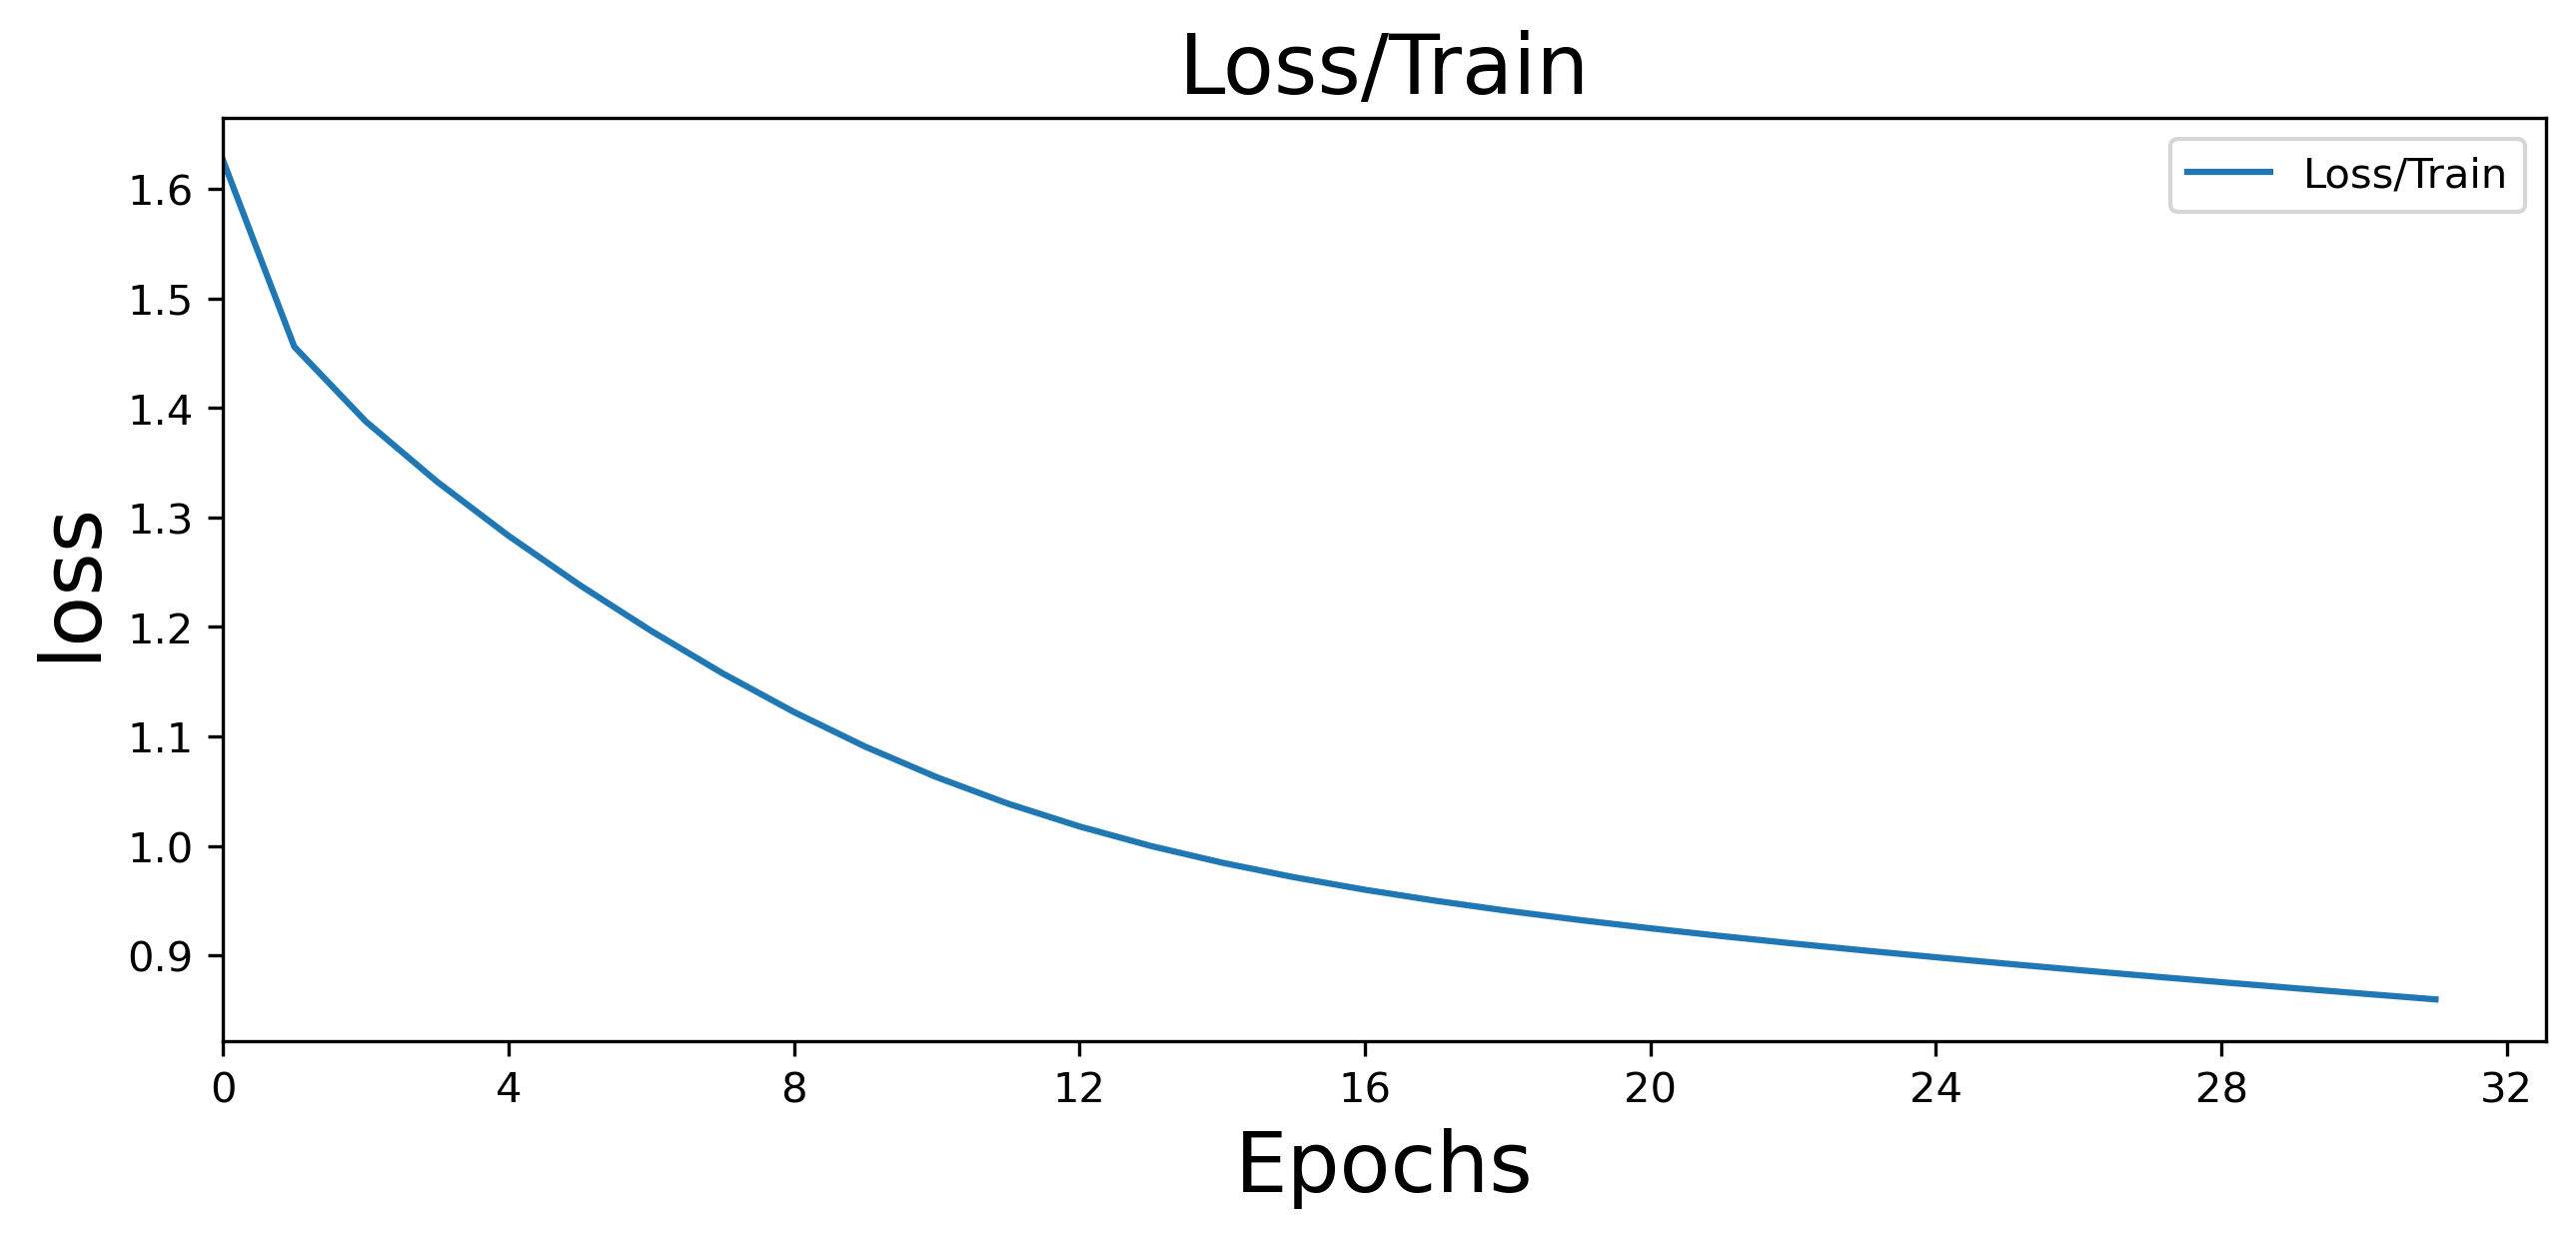

In [48]:
logger.plot_summary("Loss/Train")

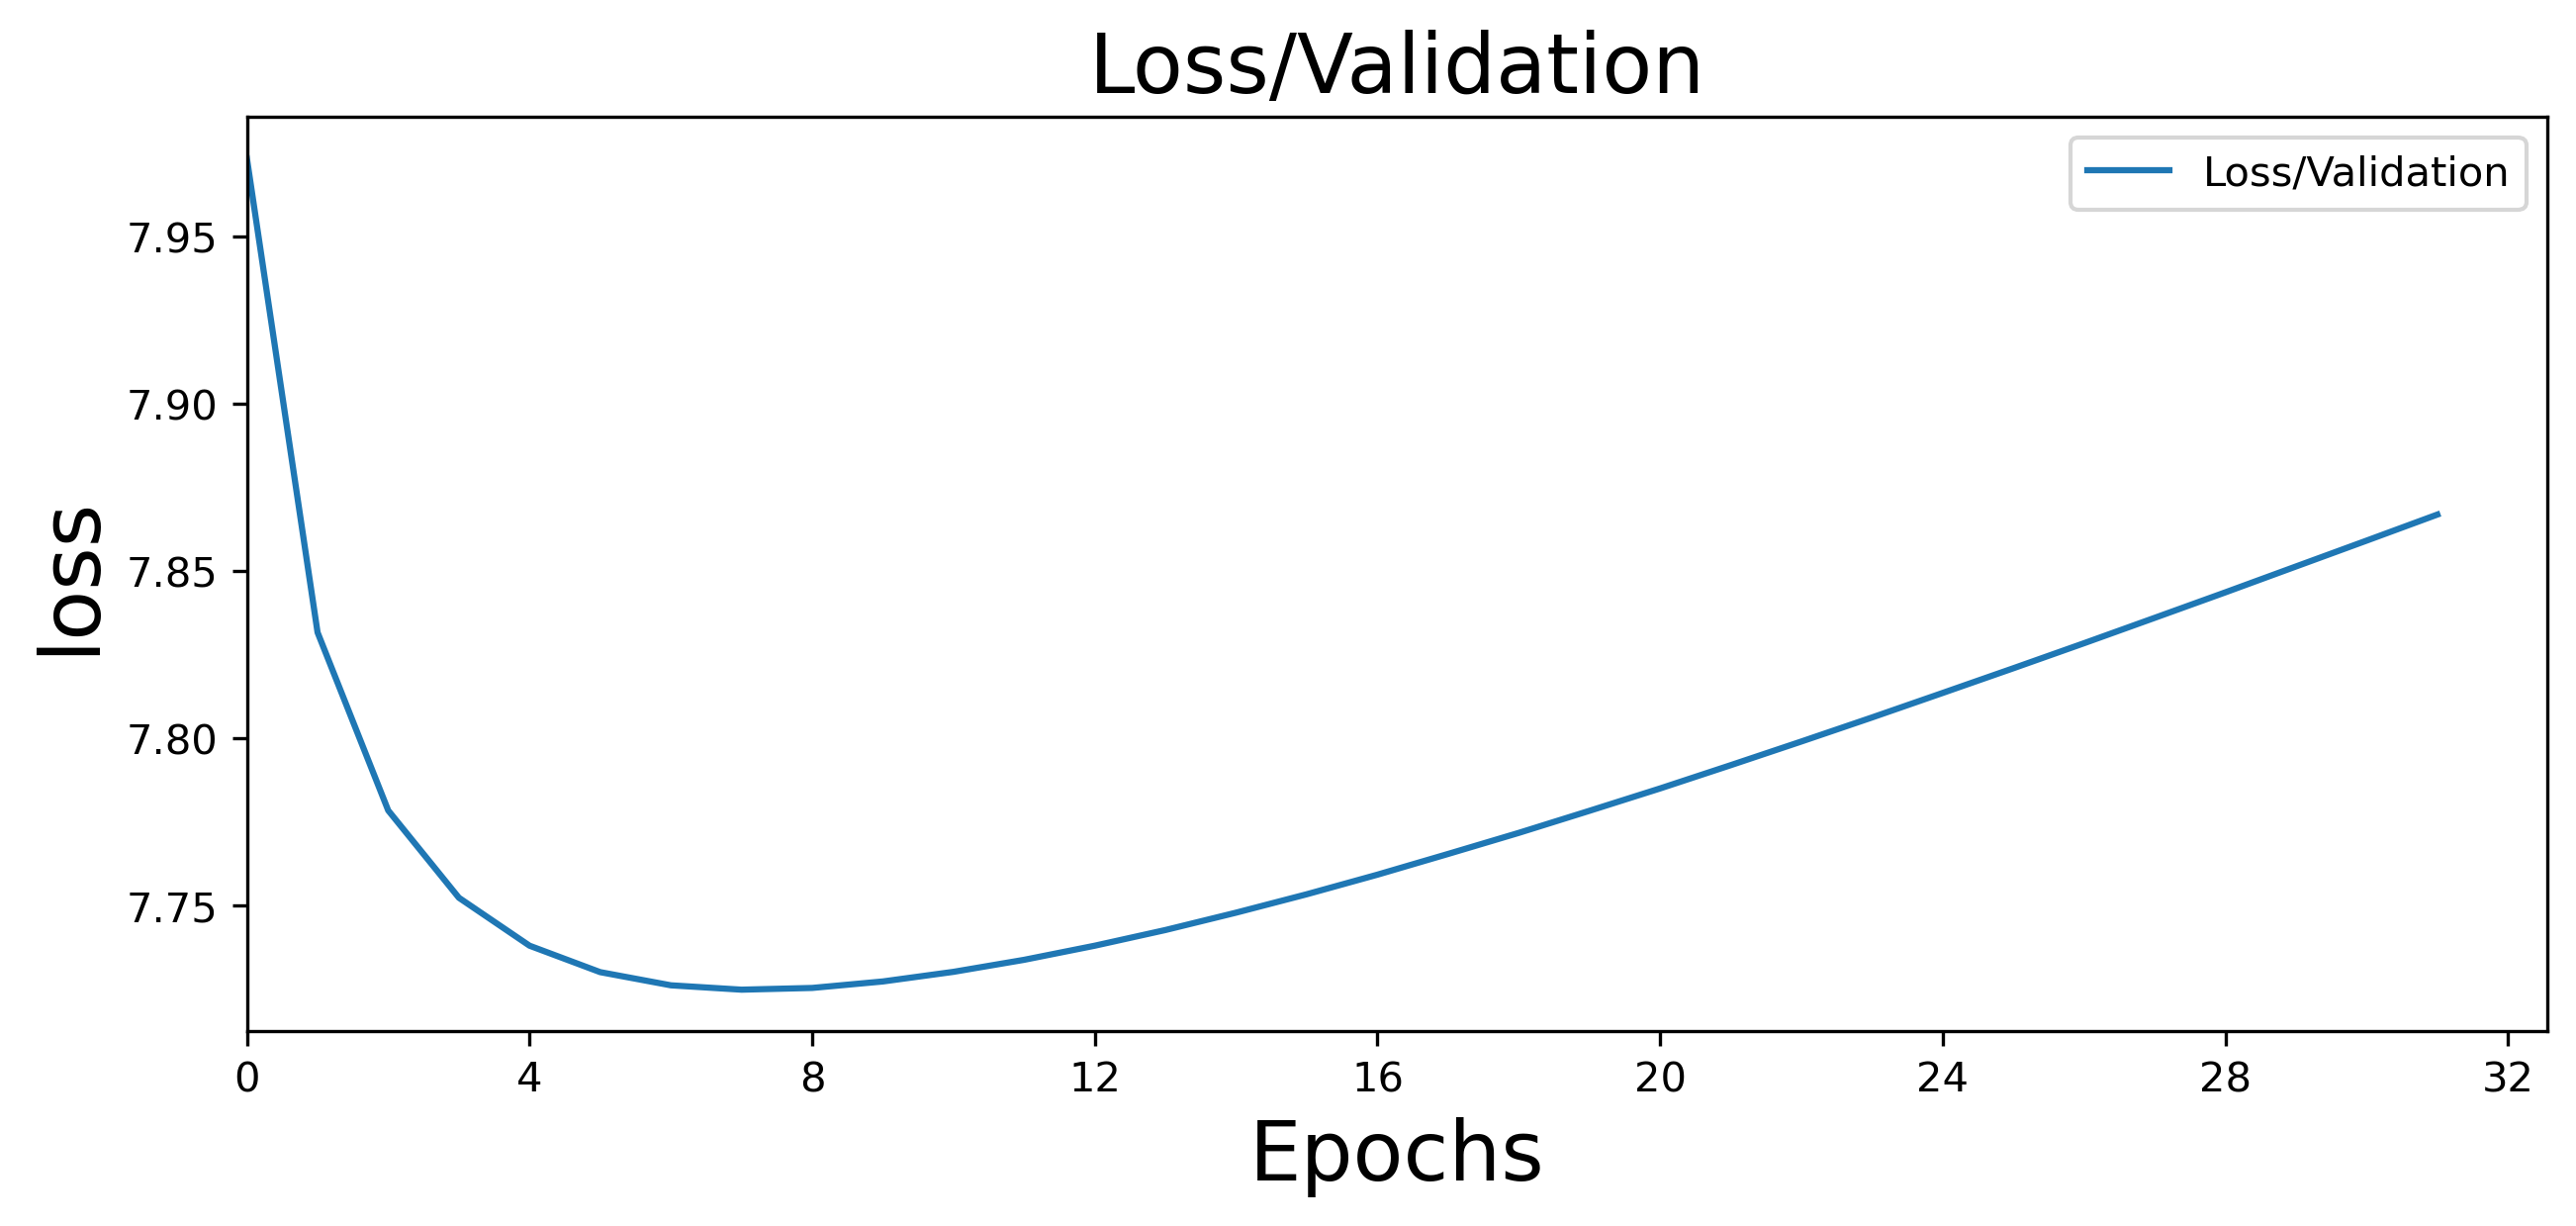

In [49]:
logger.plot_summary("Loss/Validation")

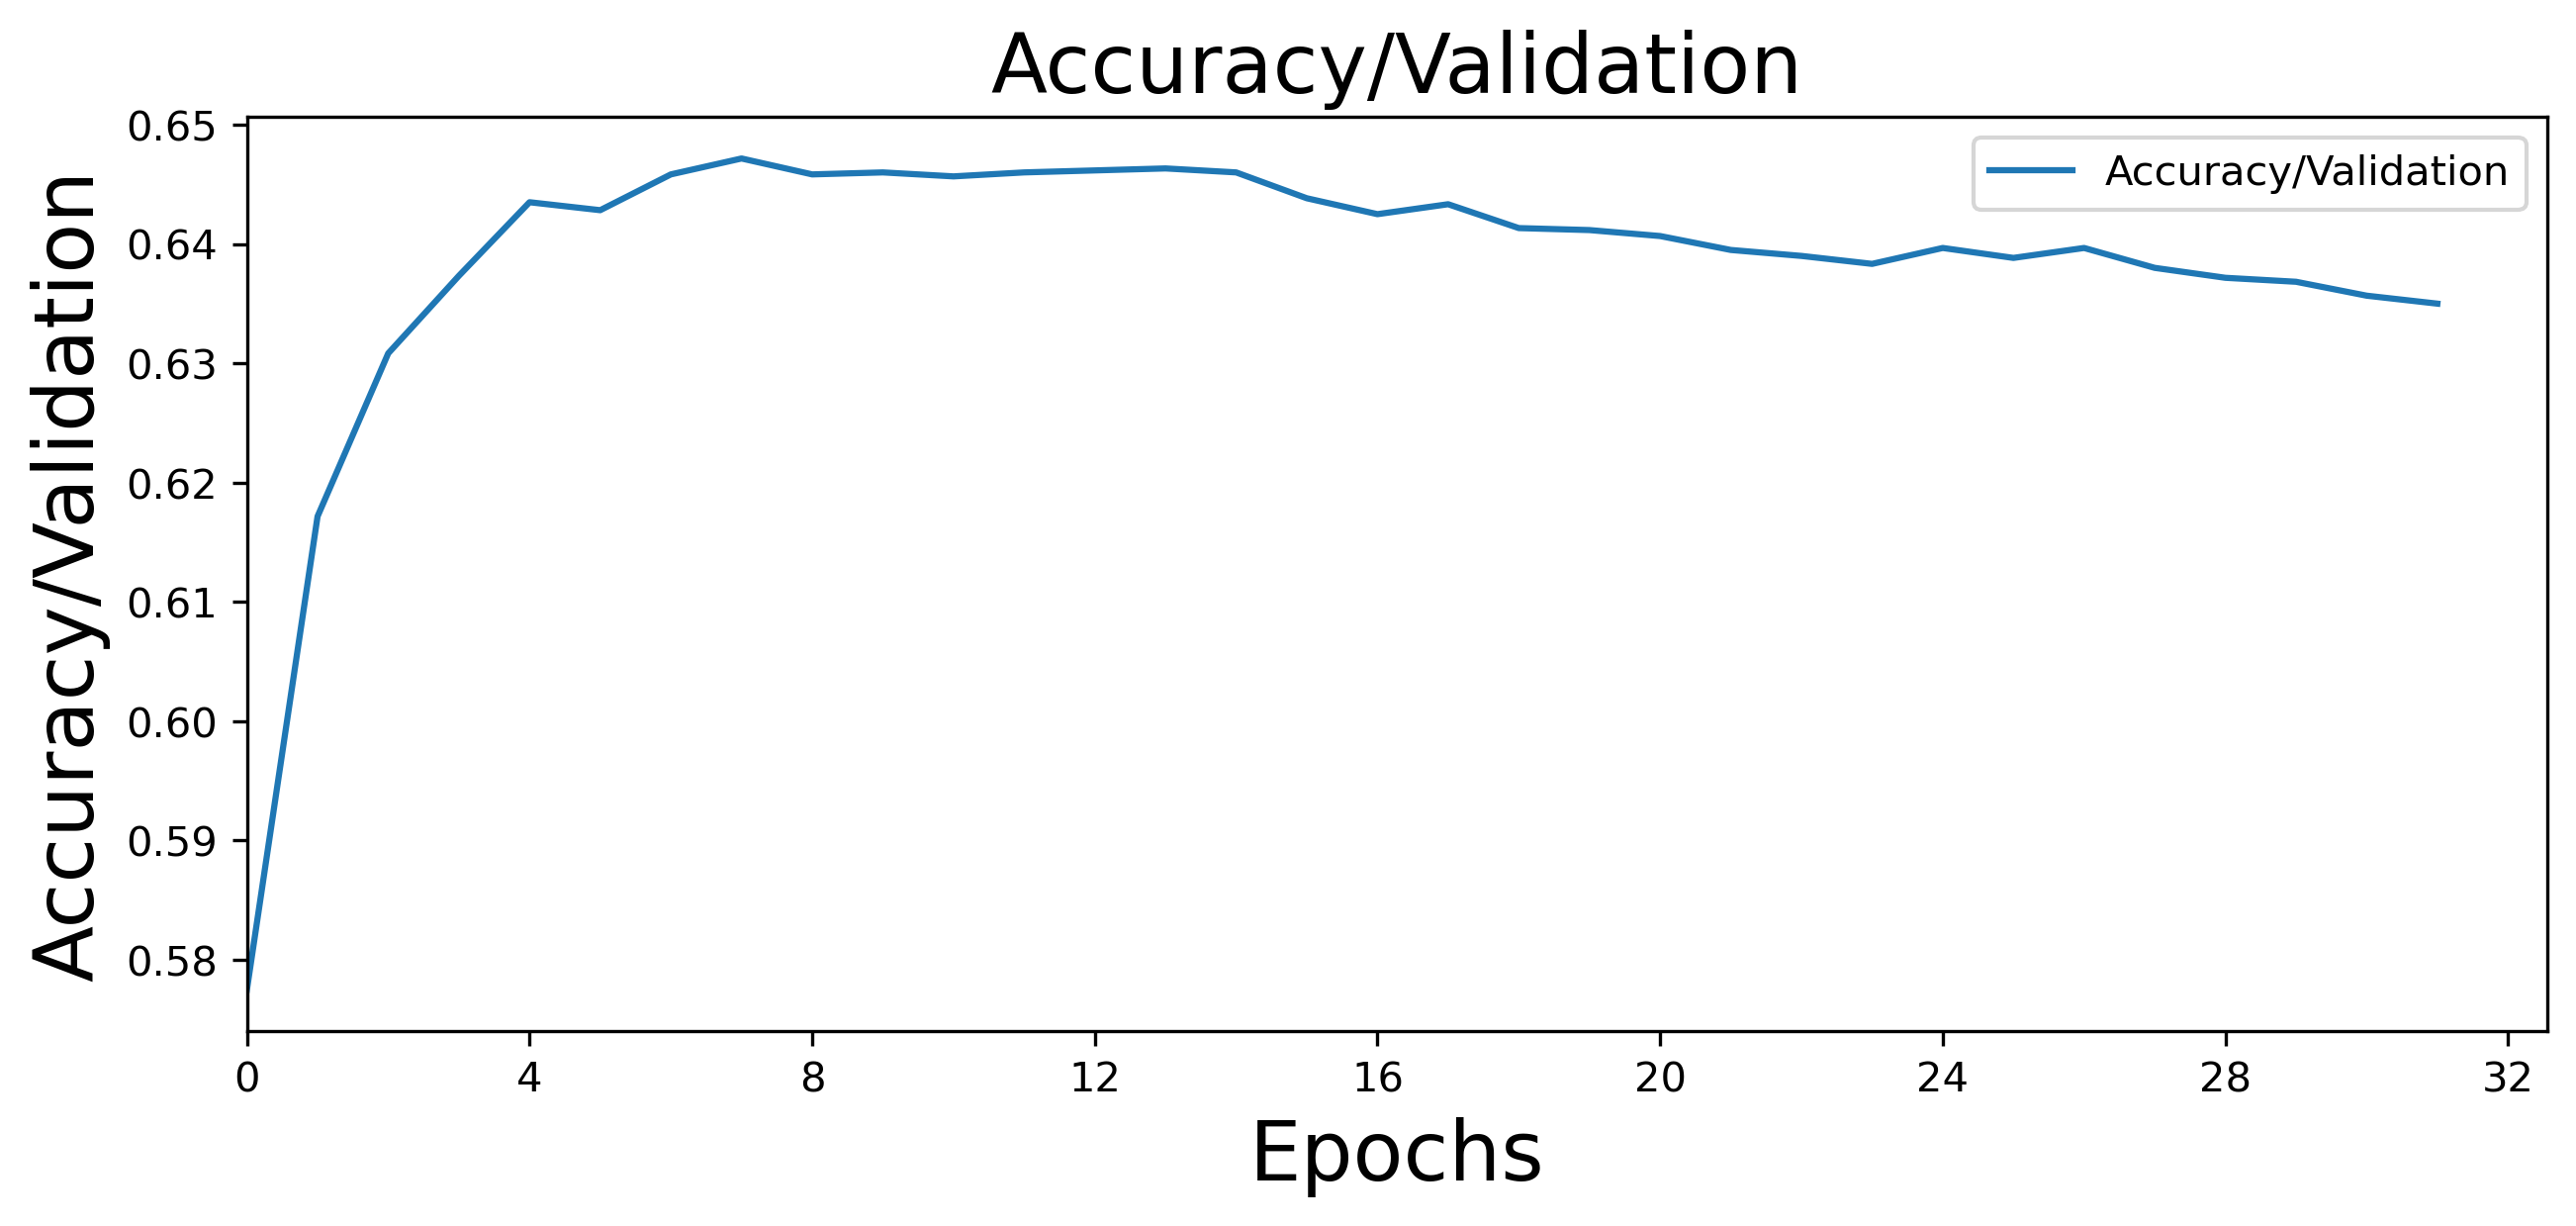

In [50]:
logger.plot_summary("Accuracy/Validation")

In [ ]:
logger.plot_summary("Accuracy/Test")